#Importando librerías

In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import glob 
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#Exploración

Fuente de datos: https://data.mendeley.com/datasets/r7bthvstxw/2

In [ ]:
train_folders = sorted(glob.glob('/content/drive/MyDrive/proyecto/*'))
len(train_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_vehiculo_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2) # para reordenar el tensor y cambiar las dimensiones de las imagenes
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  app.launch_new_instance()


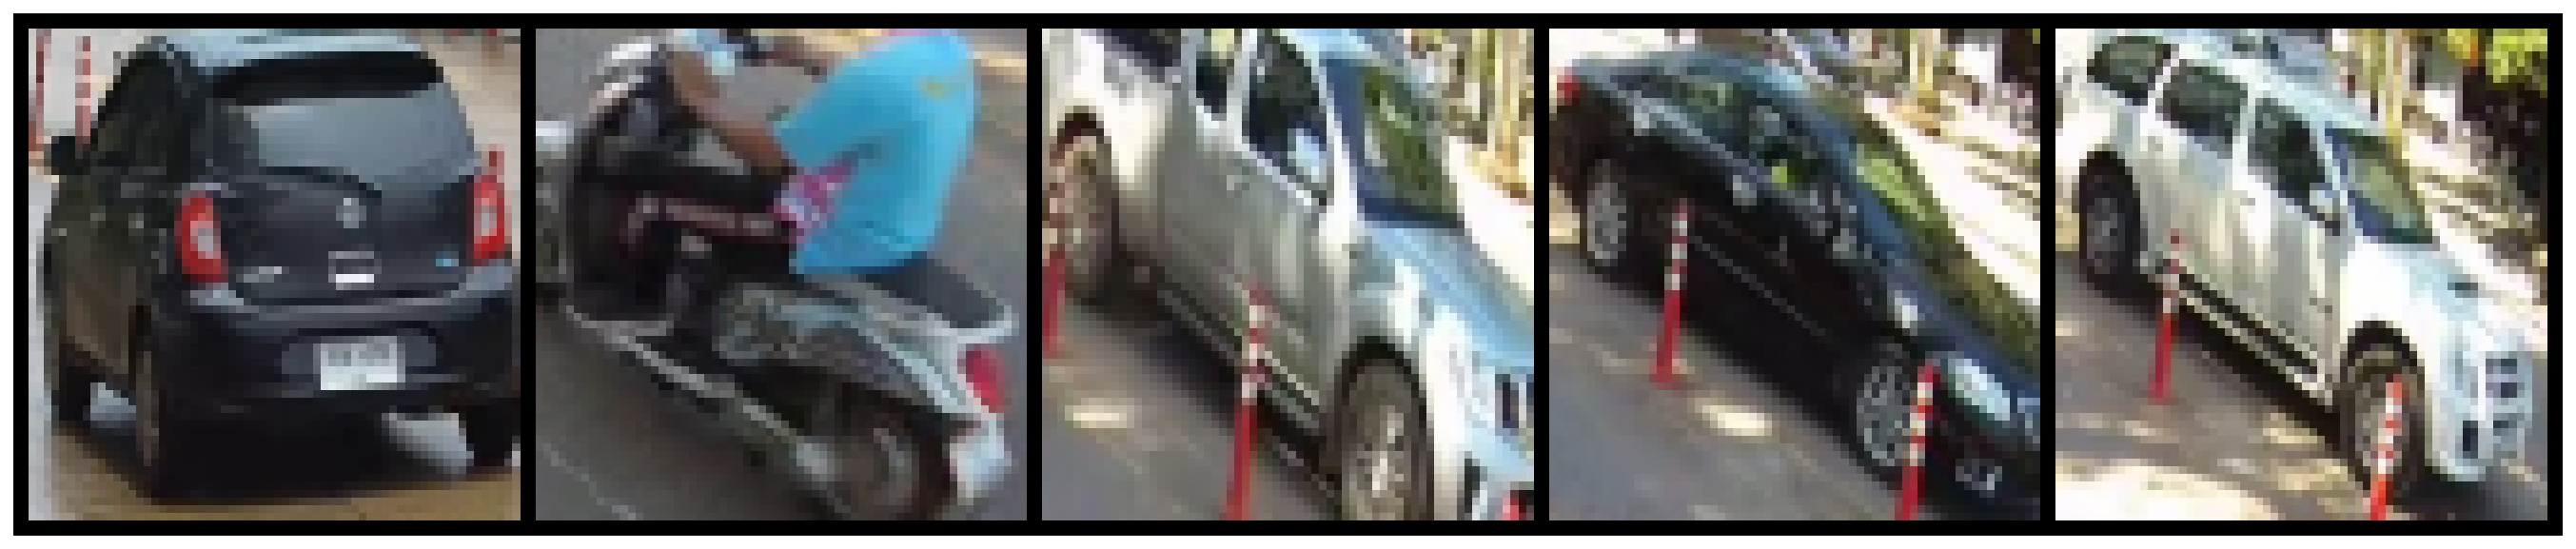

In [ ]:
sample_images = [np.random.choice(glob.glob(f'{tf}/PIC_*')) for tf in train_folders]
show_vehiculo_grid(sample_images)

Otra forma de visualización

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))]) # normalizamos para asegurar que cada pixel de entrada tenga una distribucion de datos similar

dataset = ImageFolder('/content/drive/MyDrive/proyecto/', transform=transform) # transformando a tensores las imagenes
classes = dataset.classes
data_loader = DataLoader(dataset, batch_size=20, shuffle=True) # utilizando dataloader

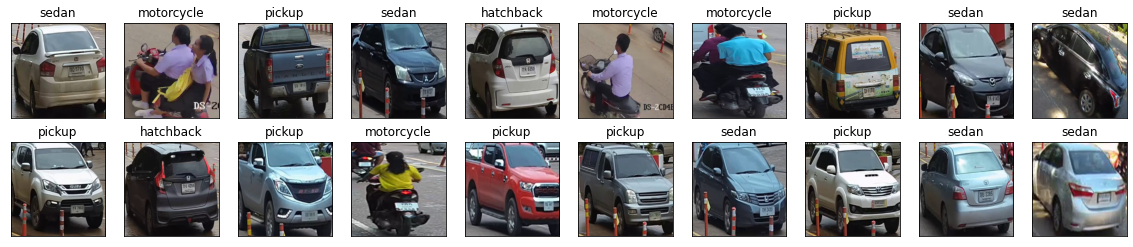

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(data_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
#Conteo de imagenes por cada clase
labels = {}
for label in classes:
  labels[label] = 0
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
for data in data_loader:
  img, label = data
  labels[classes[label.item()]] += 1
print(labels)

{'hatchback': 181, 'motorcycle': 122, 'pickup': 478, 'sedan': 400, 'suv': 129}


#CONSTRUYENDO UN DATASET

In [ ]:
class_names = ['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv' ]
class_indices = [0, 1, 2, 3,4] # asignando un indice a cada clase

In [ ]:
!rm -rf data

DATA_DIR = Path('/content/drive/MyDrive/proyecto/data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True) # creando sub carpetas para el proyecto

Usare el 80% de las imagenes para entrenar , 10% para test y otro 10% para validación

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob.glob(f'{train_folders[cls_index]}/PIC_*'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/') # Colocando las imagenes en sus respectivas carpetas 

hatchback: 181
motorcycle: 122
pickup: 478
sedan: 400
suv: 129


DATA AUGMENTATION: para aumentar el tamaño del dataset train. 
Tambien pasaremos a tensor todas las imagenes y se le aplicará una normalización.

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256), 
  T.RandomRotation(degrees=15), # aplicamos rotationes de 15 grados 
  T.RandomHorizontalFlip(), 
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums) #Normalizamos para obtener datos dentro de un rago y reducir la asimetría, esto ayuda  a que el modelo aprenda más rapido y mejor
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Aplicamos algunos cambios de tamaño aleatorios, rotación y giros horizontales. Luego, normalizo los tensores utilizando valores preestablecidos para cada canal. Este es un requisito de los modelos pre-entrenados en Torchvision. Crearé un conjunto de datos de PyTorch para cada carpeta de conjunto de datos de imagen y cargadores de datos(DATALOADERS) para facilitar el entrenamiento:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=12) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


También almacenaré la cantidad de ejemplos en cada conjunto de datos y los nombres de las clases para más adelante:

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 133, 'train': 1046, 'val': 131}

In [ ]:
class_names

['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv']

Podemos revisar algunas imágenes de ejemplo con transformaciones aplicadas. También necesitamos revertir la normalización y reordenar los canales de color para obtener los datos de imagen correctos:

In [ ]:
data_loaders_v2 = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=2) 
  for d in DATASETS
} # creo un data loader solo para la visualizacion

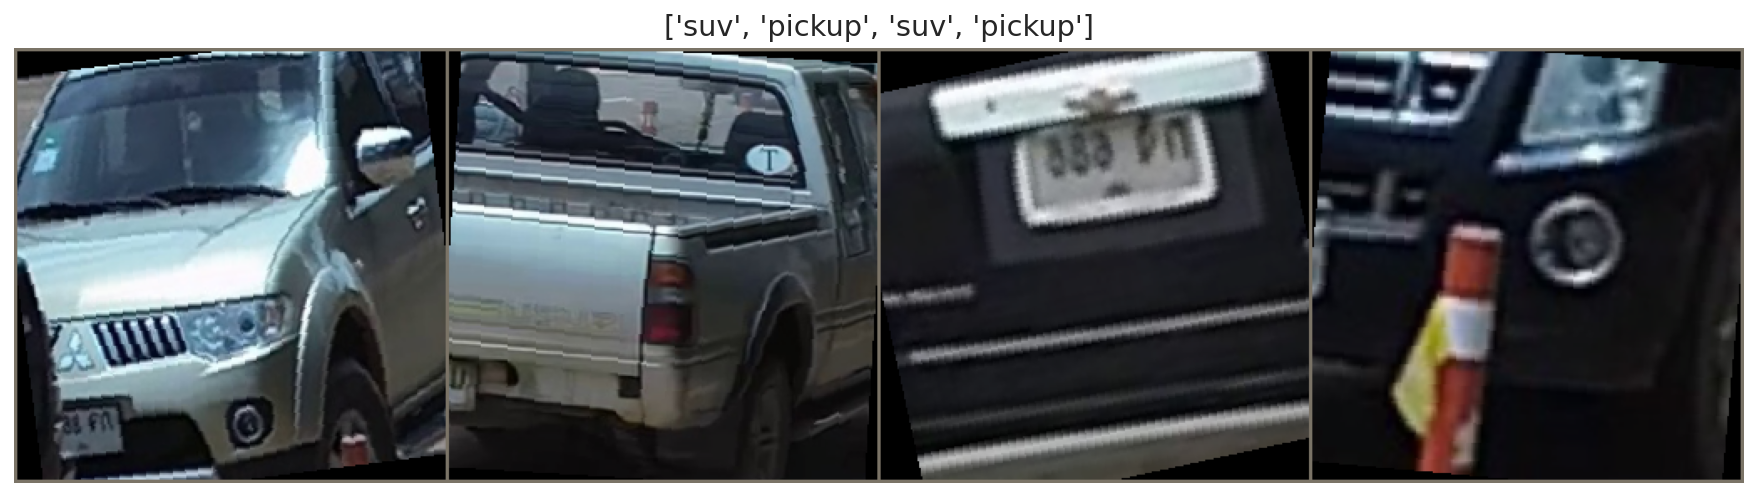

In [ ]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    img = std * img + mean # revertimos la normalizacion que orinalmente es:   (input[channel] - mean[channel]) / std[channel]
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    if title is not None:
      plt.title(title)
    plt.axis('off')

dataiter = iter(data_loaders_v2['train'])
images, labels = dataiter.next()
out = torchvision.utils.make_grid(images)

fig = plt.figure(figsize=(20, 4))


imshow(out, title=[class_names[x] for x in labels])


#Utilizando un modelo pre-entrenado:

Usaré Transfer Learning para copiar la arquitectura de la mobilenet_v2. Además usaré los pesos aprendidos del modelo.

In [ ]:
def create_model(n_classes):
  model = models.mobilenet_v2(pretrained=True)

  num_ftrs = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(num_ftrs, n_classes)

  return model.to(device)


Reutilizo casi todo excepto el cambio de la capa de salida. Esto es necesario porque la cantidad de clases en mi conjunto de datos es diferente a la cantidad de clases con que se entrenó a mobilenet_v2.

In [ ]:
base_model = create_model(len(class_names))

In [ ]:
print(base_model.classifier) # podemos ver  que solo se enfocará en 5 out_features, correspondientes a nuestras 5 clases

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


#ENTRENANDO
Creando funciones para entrenar y evaluar el modelo.

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device) # pasando a GPU
    labels = labels.to(device) # pasando a GPU

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels) # Calcular el error

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward() # backpropagation
    optimizer.step() # realiza una actualización de parámetros basada en el gradiente actual (almacenado en el atributo .grad de un parámetro) 
    optimizer.zero_grad() # limpiar gradientes

  scheduler.step() # cambia la tasa de aprendizaje cada determinado numero de epocas

  return correct_predictions.double() / n_examples, np.mean(losses)

Convirtiendo el modelo en modo de entrenamiento y le pasolos datos. Después de obtener las predicciones, obtenemos la clase con máxima probabilidad junto con el loss (perdida), por lo que podemos calcular el epoch loss y la precisión (accuracy). También usamos un scheduler(programador) de tasa de aprendizaje 

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Definiendo Funcion de entrenamiento + evaluacion

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=100):
  optimizer = optim.Adam(model.parameters(), lr=0.001) # UTilizaré el optimizador Adam
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device) # ejecutamos el modelo 

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.1453930880084182 accuracy 0.5697896749521988
Val   loss 0.7205007791519165 accuracy 0.6946564885496183

Epoch 2/100
----------
Train loss 0.7829932055690072 accuracy 0.7055449330783938
Val   loss 0.8905527174472809 accuracy 0.7862595419847328

Epoch 3/100
----------
Train loss 0.7503242808761019 accuracy 0.7122370936902486
Val   loss 0.6086463928222656 accuracy 0.8244274809160305

Epoch 4/100
----------
Train loss 0.7145234716661049 accuracy 0.7284894837476099
Val   loss 0.4703716903924942 accuracy 0.8244274809160305

Epoch 5/100
----------
Train loss 0.5937051673730215 accuracy 0.7762906309751434
Val   loss 0.5907943964004516 accuracy 0.8015267175572519

Epoch 6/100
----------
Train loss 0.5643192358089216 accuracy 0.7734225621414914
Val   loss 0.25383155564777554 accuracy 0.8931297709923663

Epoch 7/100
----------
Train loss 0.5094383042870145 accuracy 0.8059273422562141
Val   loss 0.32530447989702227 accuracy 0.8396946564885496

Epoch 8/100
----------
Train loss 0.48202

In [ ]:
def plot_training_history(history): # Definimos una funcion para poder ver de forma grafica como fue evolucionando el aprendizaje 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  t_acc=torch.FloatTensor(history['train_acc'])
  t_acc= t_acc.tolist() # tranformamos el tensor que almacenaba los datos de train accuracy en una lista 

  v_acc=torch.FloatTensor(history['val_acc'])
  v_acc= v_acc.tolist() # tranformamos el tensor que almacenaba los datos de val accuracy en una lista 

  ax2.plot(t_acc, label='train accuracy')
  ax2.plot(v_acc, label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

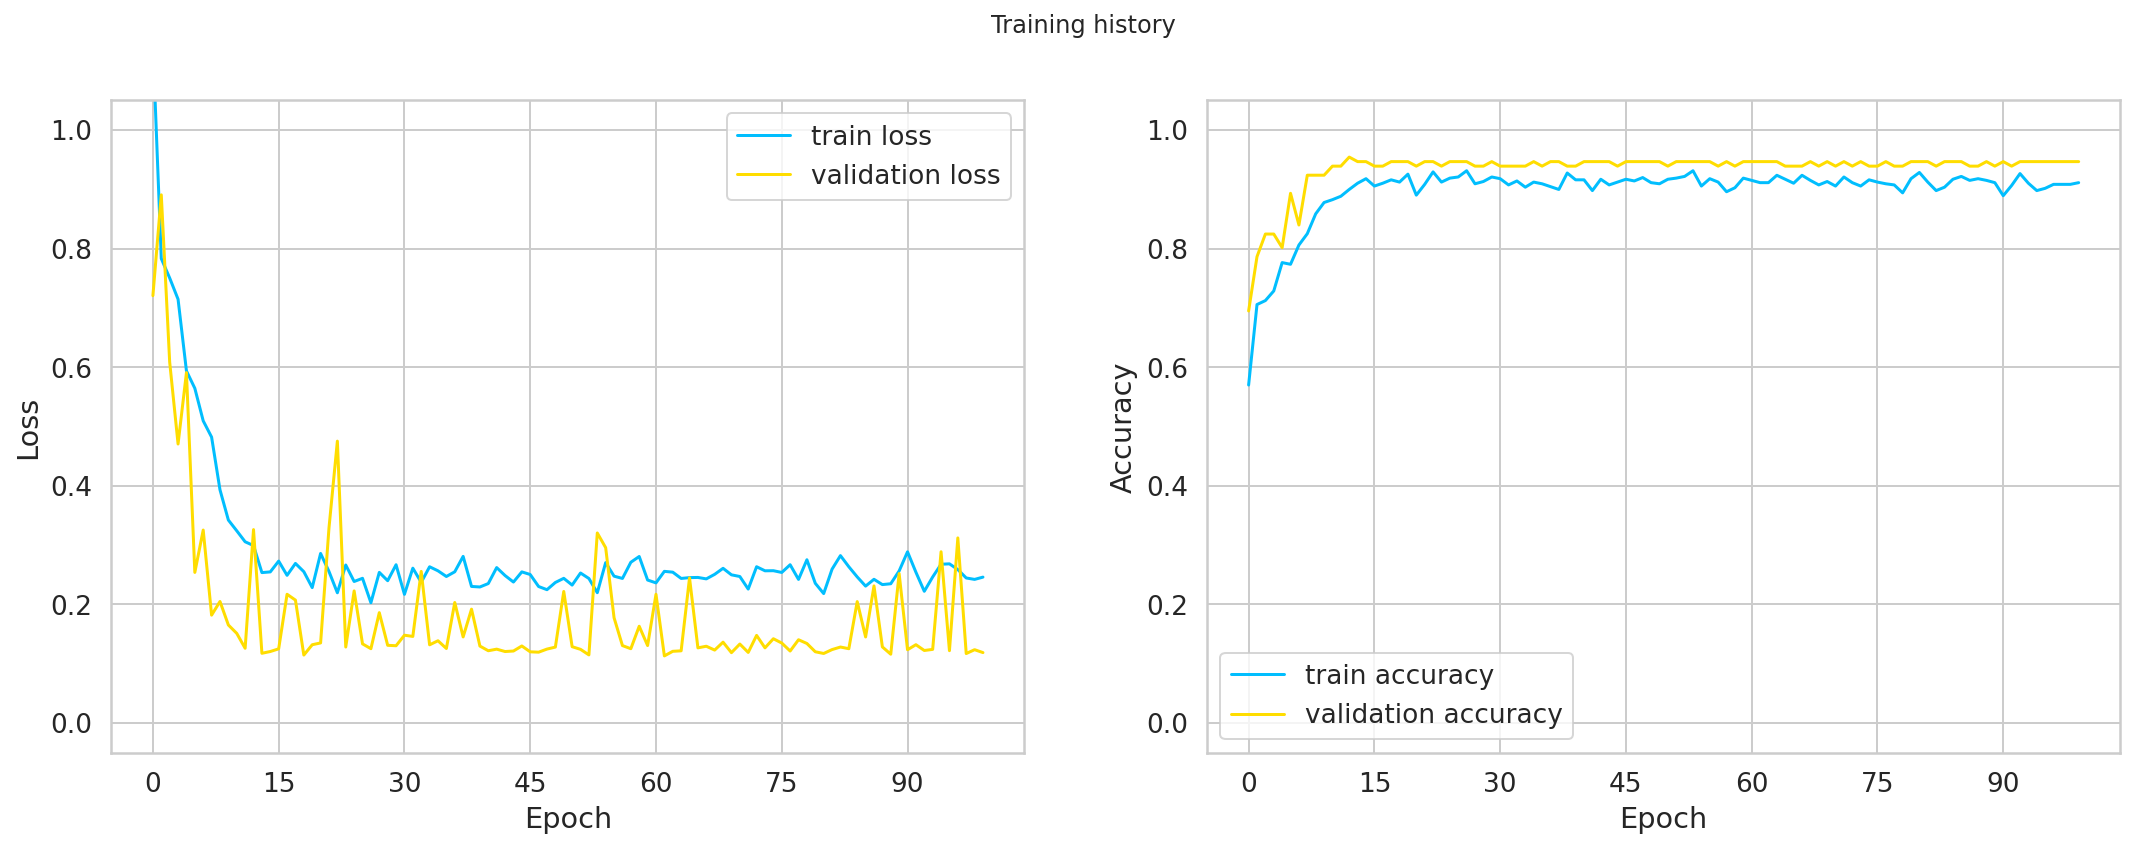

In [ ]:
plot_training_history(history)

# Evaluacion con data del dataset TEST

In [ ]:
def show_predictions(model, class_names, n_images):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20, 4))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']): # pasamos imagenes del dataloader test
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


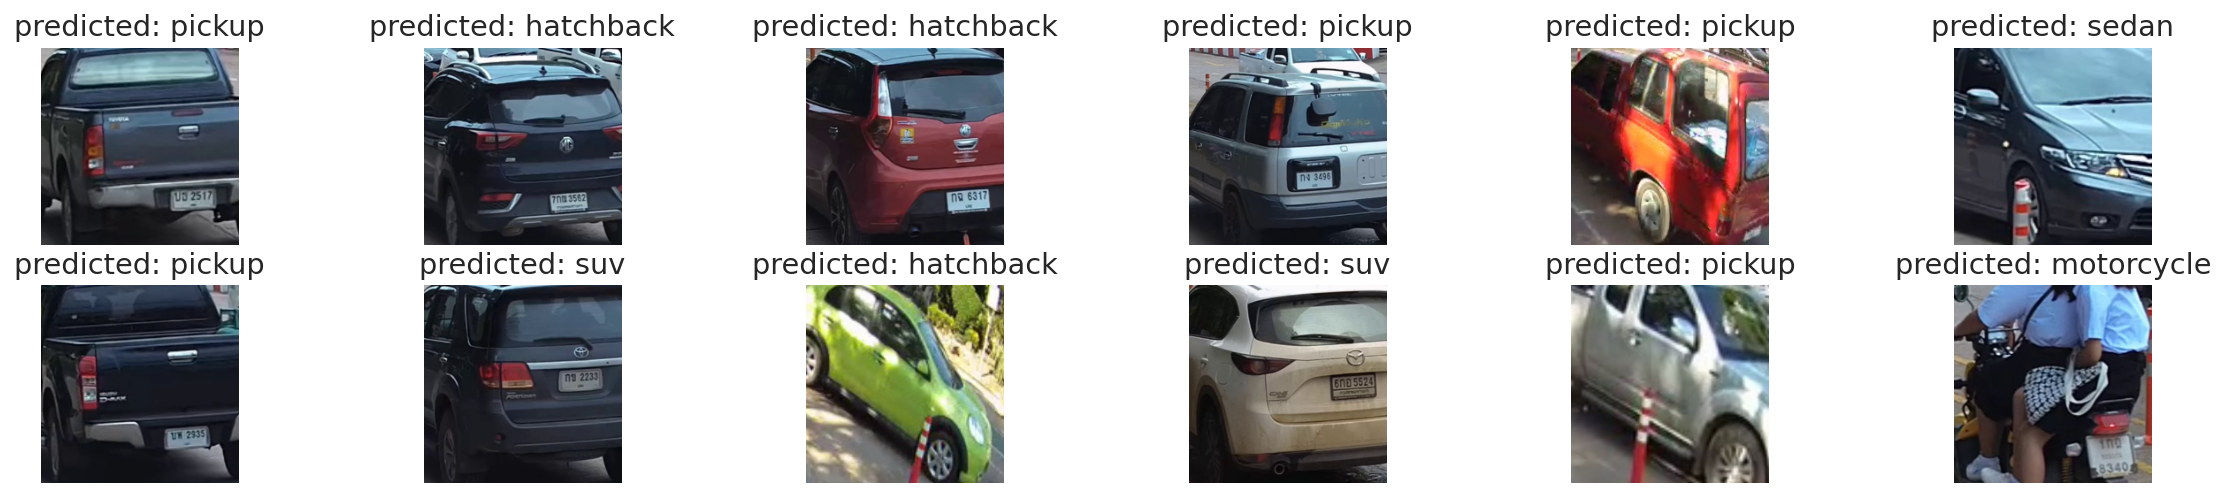

In [ ]:
show_predictions(base_model, class_names, n_images=12) # escogemos 12 imagenes

In [ ]:
def get_predictions(model, data_loader): # creamos una funcion para utilizar el modelo y predecir todo el dataloader de test y comparar con las clases reales
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names)) # Métricas de nuestro modelo

              precision    recall  f1-score   support

   hatchback       0.95      0.95      0.95        19
  motorcycle       1.00      1.00      1.00        13
      pickup       0.96      0.96      0.96        48
       sedan       0.93      1.00      0.96        40
         suv       0.90      0.69      0.78        13

    accuracy                           0.95       133
   macro avg       0.95      0.92      0.93       133
weighted avg       0.95      0.95      0.95       133



Se observa que el modelo tiene un accuracy del 95%, lo cual es bastante bueno. Al parecer presenta más inconvenientes para atinar con la clase suv, ya que tiene el menor  f1-score de 78%. Esto puede deberse a que falte más data de entrenamiento para dicha clase o que de por sí , las diferencias entre algunas clases sean mínimas en ocasiones y eso hace que el modelo no reconozca bien el target.

#Matriz de confusión

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('verdadero vechiculo')
  plt.xlabel('vehiculo predicho');

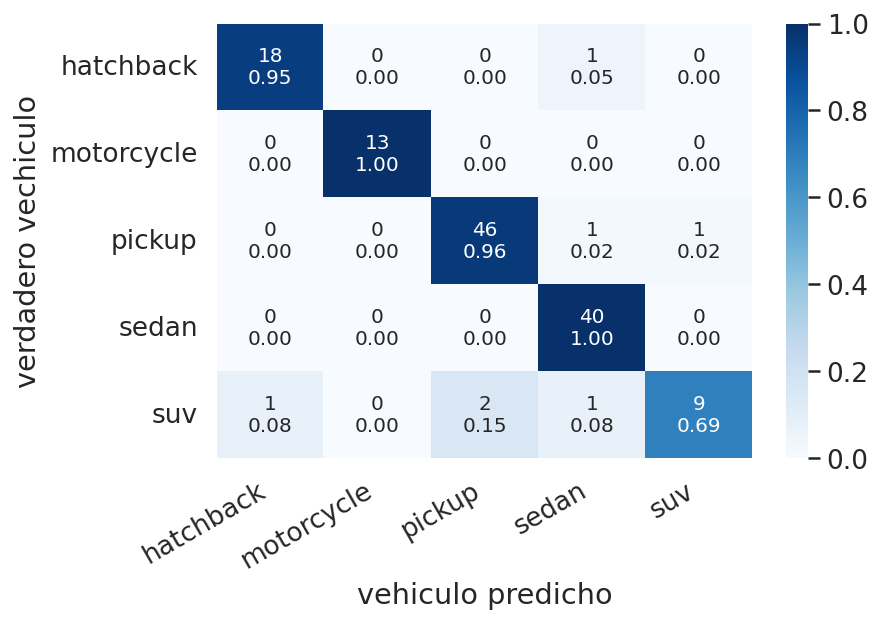

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

El modelo tiene un desempeño bastante bueno y puede reconocer muy bien las clases. Parece que suele confundir más las clases suv, clase pickup , sedan y hatchback, pero la clase motocicleta la predice de manera perfecta.

#Visualizando las probabilidades

In [ ]:
def predict_proba(model, image_path): # creando una funcion para predecir  y extraer la probabilidad que asume el modelo
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(base_model, '/content/drive/MyDrive/proyecto/data/test/sedan/PIC_106.jpg' ) #cogemos un ejemplo de la clase sedan
pred

array([3.2924823e-02, 3.5566114e-05, 1.8714558e-02, 6.5595645e-01,
       2.9236856e-01], dtype=float32)

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

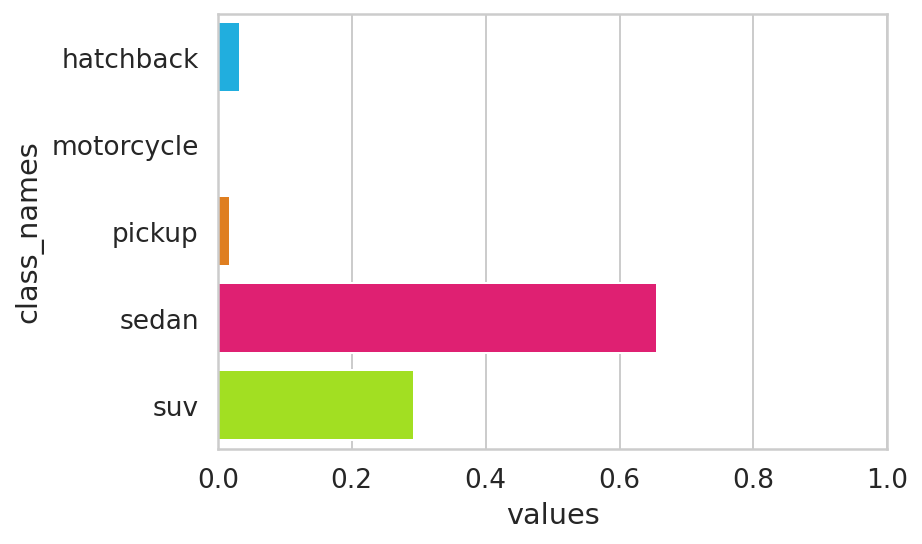

In [ ]:
show_prediction_confidence(pred, class_names)

Notamos que el modelo predice correctamente, sin embargo le asigna cierta probabilidad media a la clase suv también.

Fin.